# 1. Receptive field and parameter count (1 point)

Recall that the *receptive field* refers to size of the region in the input that are visible to a given activation (or neuron) in a convolutional neural network. "Visible" here means that the values of those inputs affect the value of the activation. In all of the following questions, assume that the input image is arbitrarily large, so you don't need to worry about boundary effects or padding.

1. Consider a convolutional network which consists of three convolutional layers, each with a filter size of 3x3, and a stride of 1x1. What is the receptive field size of one of the activations at the final output?
1. What is the receptive field if the stride is 2x3 at each layer?
1. What is the receptive field if the stride is 2x2 at each layer, and there is a 2x2 max-pooling layer with stride 2x2 after each convolutional layer?
1. Assume that the input image has 3 channels, the three convolutional layers have 16, 32, and 64 channels respectively, and that there are no biases on any of the layers. How many parameters does the network have?

In [1]:
import numpy as np

# This code was built upon code from 
# https://github.com/rogertrullo/Receptive-Field-in-Pytorch/
# https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks


def compute_N(outs,f,s):
    n_dims = len(outs)
    rez = np.zeros(n_dims)
    for i in range(n_dims):
        rez[i] =s[i]*(outs[i]-1)+f[i] 
    return rez

def compute_RF(layers):
    # Layers are given as tuple of tuples in (Filter, Stride)
    outs=np.ones(len(layers[-1][0]))
    for f,s in reversed(layers):
        n_dims = len(f)
        outs=compute_N(outs,f,s)
    return np.prod(outs)

In [2]:
### Answer to Q1.1
layers = [((3,3),(1,1))]*3
compute_RF(layers)

49.0

In [3]:
### Answer to Q1.2
layers = [((3,3),(2,3))]*3
compute_RF(layers)

405.0

In [4]:
### Asnwer to Q1.3
layers = [((3,3),(2,2)), ((2,2),(2,2))]*3
compute_RF(layers)

7225.0

In [5]:
### No outside sources for the following code
# https://learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/


def compute_layer_params(layer, bias):
    k1, k2, c_i, c_o = layer
    return (k1*k2*c_i + int(bias))*c_o

def compute_network_params(layers, bias=False):
    #Layers is a list of tuples (Filter_H, Filter_W, Input_Channels, Output_Channel)
    # Number of parameters is independent of stride? 
    return np.sum([compute_layer_params(layer, bias) for layer in layers])

In [6]:
### Answer to Q1.4

layers = [(3,3,3,16),(3,3, 16, 32), (3,3,32,64)]
compute_network_params(layers)

23472

# 2. CIFAR-10 classification (3 points)

CIFAR-10 is a standard dataset where the goal is to classify 32 x 32 images into one of 10 classes. The goal of this problem is simple: build and train a convolutional neural network to perform classification on CIFAR-10. The problem is intentionally extremely open-ended! There are dozens (hundreds?) of tutorials online describing how to train a convnet on CIFAR-10 - please seek them out and make use of them. I recommend getting started with the [CIFAR-10 tutorial from PyTorch](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb) which includes code for loading the dataset and evaluating performance on it. You are welcome to use any other resource that you want (but please cite it!) - as I mentioned there are many, many tutorials online, and googling for help is an utterly crucial skill for a researcher! You will be graded on the final test accuracy achieved by your model:

- 60% accuracy or higher: 2/3 points
- 75% accuracy or higher: 3/3 points
- Highest accuracy in the class: 4/3 points!

Note that in order for us to know the final performance of your model, you will need to implement a function that computes the accuracy of your model on the test set (which appears in both of the linked tutorials above). The only rules are: You can only train your model on the CIFAR-10 training set (i.e. you can't use pre-trained models or other datasets for additional training, and you certaintly can't train on the CIFAR-10 test set!), and you must train the model on the free Colab GPU or TPU. This means you can only train the model for an hour or so! This is *much* less compute than is typically used for training CIFAR-10 models. As such, this is as much an exercise in building an accurate model as it is in building an efficient one. This is a popular game to play, and to the best of my knowledge the state-of-the-art is [this approach](https://myrtle.ai/learn/how-to-train-your-resnet/) which attains 96% accuracy in only *26 seconds* on a single GPU! (note that the final link on that page is broken; it should be [this](https://myrtle.ai/learn/how-to-train-your-resnet-8-bag-of-tricks/)).

There are lots of things you can try to make your model more accurate and/or more efficient:

1. Deeper models
1. Residual connections
1. [Data augmentation and normalization](https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html#image-augmentation)
1. Regularization like dropout or weight decay
1. [Learning rate schedules](https://d2l.ai/chapter_optimization/lr-scheduler.html)
1. [Different forms of normalization](https://d2l.ai/chapter_convolutional-modern/batch-norm.html)

Note that we haven't covered all these topics in class yet, but you should be able to get to at least 60% accuracy without applying all of these ideas - and probably 75% by tweaking around a little bit. Specifically, you should be able to get about 60% accuracy by taking the basic AlexNet architecture we discussed in class and applying it directly to CIFAR-10. And, if you're feeling adventurous, feel free to go for 96% using the aforementioned blog series! Good luck!

In [1]:
#Import Dependencies 

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install wandb -qq
import wandb
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  dog  ship  bird plane


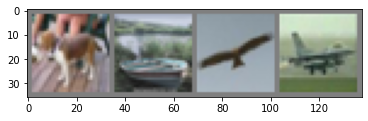

In [4]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [43]:
images.shape

torch.Size([128, 3, 32, 32])

### Start a New WANDB Run

In [5]:
run = wandb.init(project="COMP658_ConvNet", entity="dhuvik", job_type="baseline2")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
### Create an Artifact for the Data

data_artifact = wandb.Artifact("DataRepository", type="data")

In [12]:
train_table100 = wandb.Table(data=list(trainset)[:100], columns=['image', 'label'])
test_table100 = wandb.Table(data=list(testset)[:100], columns=['image', 'label'])

In [13]:
### Add the Training and Test Data to the Artifact

data_artifact.add(train_table100, "Transformed Training Dataset 100")
data_artifact.add(test_table100, "Transformed Test Dataset 100")

ArtifactManifestEntry(path='Transformed Test Dataset 100.table.json', digest='GmGLqy/A4eE6hqs40qVf/w==', ref=None, birth_artifact_id=None, size=6400161, extra={}, local_path='/root/.local/share/wandb/artifacts/staging/tmpstpru0gz')

In [23]:
run.finish()  # Upload to the weights and biases server

### Implementing the Baseline Model

**Note:** The baseline model along with the code to calculate accuracy is adopted from the tutorial linked in the HW

In [24]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Forward Call 1 Outdim * kernel * kernel
        self.fc2 = nn.Linear(120, 84) # Forward Call 2 Squeeze down to dimension of 84
        self.fc3 = nn.Linear(84, 10) # Forward Call 3 Squeeze to num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
bNet = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bNet.parameters(), lr=0.001, momentum=0.9)

In [3]:
def calc_test_loss(model, data_loader, criterion, device):
    with torch.no_grad():
        _, labels = next(iter(data_loader))
        batch_size = len(labels)
        running_loss = 0
        for inps, labels in data_loader:
            inps = inps.to(device)
            labels = labels.to(device)
            touts = model(inps)
            tloss = criterion(touts, labels)
            running_loss += tloss.item()
        return running_loss / len(data_loader)

def calc_test_accuracy(model, test_loader, device):
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

In [4]:
def train_epochs(n_epochs, train_loader, test_loader, model, optimizer, criterion, log_every=1000, dev=device):
    #run = wandb.init(project="COMP658_ConvNet", entity="dhuvik", job_type="training_run", settings=wandb.Settings(start_method="thread"))
    #wandb.watch(model, log_freq=log_every)
    # See how often to log iterations
    if log_every == None:
        log_every = len(train_loader)
    elif log_every > len(train_loader):
        log_every = len(train_loader)

    train_loss = []
    test_loss = []
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(dev), labels.to(dev)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % log_every == log_every - 1:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / log_every))
                train_loss += [running_loss / log_every]
                test_loss += [calc_test_loss(model, test_loader, criterion, dev)]
                #wandb.log({"train_loss": running_loss / log_every})
                #wandb.log({"test_loss": calc_test_loss(model, test_loader, criterion, dev)})
                running_loss = 0.0

    print('Finished Training')
    #run.finish()
    return model, train_loss, test_loss

In [50]:
opt_baseline = train_epochs(35, trainloader, testloader, bNet, optimizer, criterion, log_every=250)

[1,   250] loss: 2.302
[2,   250] loss: 2.298
[3,   250] loss: 2.280
[4,   250] loss: 2.181
[5,   250] loss: 2.042
[6,   250] loss: 1.943
[7,   250] loss: 1.811
[8,   250] loss: 1.695
[9,   250] loss: 1.607
[10,   250] loss: 1.561
[11,   250] loss: 1.516
[12,   250] loss: 1.479
[13,   250] loss: 1.446
[14,   250] loss: 1.424
[15,   250] loss: 1.394
[16,   250] loss: 1.367
[17,   250] loss: 1.350
[18,   250] loss: 1.328
[19,   250] loss: 1.307
[20,   250] loss: 1.286
[21,   250] loss: 1.275
[22,   250] loss: 1.251
[23,   250] loss: 1.238
[24,   250] loss: 1.230
[25,   250] loss: 1.213
[26,   250] loss: 1.190
[27,   250] loss: 1.168
[28,   250] loss: 1.161
[29,   250] loss: 1.141
[30,   250] loss: 1.128
[31,   250] loss: 1.123
[32,   250] loss: 1.102
[33,   250] loss: 1.088
[34,   250] loss: 1.075
[35,   250] loss: 1.065
Finished Training


In [51]:
calc_test_accuracy(opt_baseline, testloader, device)

Accuracy of the network on the test images: 59 %


### Moving Past the Baseline: Deepening the Network and Adding BatchNorm

In [72]:
def conv_block_scheme1(layer_specs):
    # layer_specs = [(kernel, stride, padding, in_channels, out_channels)]
    layers = []
    for spec in layer_specs:
        kernel, stride, padding, in_channels, out_channels = spec
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [122]:
def conv_block_scheme2(layer_specs):
    # layer_specs = [(kernel, stride, padding, in_channels, out_channels)]
    layers = []
    for spec in layer_specs:
        kernel, stride, padding, in_channels, out_channels = spec
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel, 
                                stride=stride, padding=padding, bias=False))
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel+2, 
                                stride=stride, padding=int((kernel+1)/2), bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [130]:
class BatchNormNet(nn.Module):
    def __init__(self, layer_specs, scheme):
        super(BatchNormNet, self).__init__() 
        arch = scheme(layer_specs)
        self.net = nn.Sequential(
            *arch, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096,400), nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(400,10)
        )
        
    def forward(self, x):
        y = self.net(x)
        return y

In [127]:
layer_specs = [(3,1,1,3,16), # Layer 1
                (3,1,1,16,32), # Layer 2
                (3,1,1,32,64), # Layer 3
                (3,1,1,64,64)] # Layer 4
bNet2 = BatchNormNet(layer_specs, conv_block_scheme1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bNet2.parameters(), lr=0.001, momentum=0.9)

In [128]:
# Pre-Load Lazy Loading
sample_input_batched = next(iter(trainloader))[0].to(device)
bNet2(sample_input_batched).shape

torch.Size([128, 16384])

In [92]:
opt2_earlystopping = train_epochs(14, trainloader, testloader, bNet2, optimizer, criterion, log_every=250)

[1,   250] loss: 1.811
[2,   250] loss: 1.293
[3,   250] loss: 1.107
[4,   250] loss: 0.969
[5,   250] loss: 0.878
[6,   250] loss: 0.789
[7,   250] loss: 0.735
[8,   250] loss: 0.675
[9,   250] loss: 0.619
[10,   250] loss: 0.571
[11,   250] loss: 0.509
[12,   250] loss: 0.457
[13,   250] loss: 0.409
[14,   250] loss: 0.352
Finished Training


In [93]:
calc_test_accuracy(opt2_earlystopping, testloader, device)

Accuracy of the network on the test images: 73 %


In [131]:
layer_specs = [(3,1,1,3,16), # Layer 1
                (3,1,1,16,32), # Layer 2
                (3,1,1,32,64), # Layer 3
                (3,1,1,64,64)] # Layer 4
bNet3 = BatchNormNet(layer_specs, conv_block_scheme2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bNet3.parameters(), lr=0.001, momentum=0.9)

# Pre-Load Lazy Loading
sample_input_batched = next(iter(trainloader))[0].to(device)
bNet3(sample_input_batched).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([128, 10])

In [140]:
opt3, trl, tsl = train_epochs(20, trainloader, testloader, bNet3, optimizer, criterion, log_every=250)

[1,   250] loss: 1.764
[2,   250] loss: 1.267
[3,   250] loss: 1.051
[4,   250] loss: 0.900
[5,   250] loss: 0.801
[6,   250] loss: 0.731
[7,   250] loss: 0.664
[8,   250] loss: 0.618
[9,   250] loss: 0.576
[10,   250] loss: 0.523
[11,   250] loss: 0.487
[12,   250] loss: 0.449
[13,   250] loss: 0.413
[14,   250] loss: 0.379
[15,   250] loss: 0.339
[16,   250] loss: 0.309
[17,   250] loss: 0.275
[18,   250] loss: 0.235
[19,   250] loss: 0.206
[20,   250] loss: 0.176
Finished Training


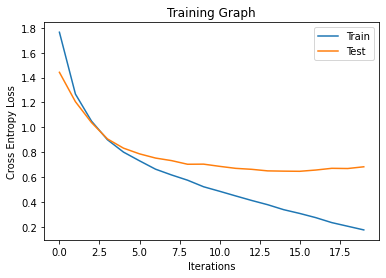

In [141]:
plt.plot(trl)
plt.plot(tsl)
plt.legend(['Train', 'Test'])
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Graph')
plt.show()

In [142]:
calc_test_accuracy(opt3, testloader, device)

Accuracy of the network on the test images: 78 %


### Moving Past Normalization: Residual Connections

In [10]:
class ResBlock(nn.Module):
    def __init__(self, layer_spec, dims_scales, scheme, ff=True, device=device):
        super(ResBlock, self).__init__() 
        arch = scheme(layer_spec, dims_scales)
        self.ff = ff
        self.convs = nn.Sequential(*arch)
    def forward(self, x):
        y = self.convs(x)
        if self.ff:
            add_conv = nn.Sequential(nn.Conv2d(x.shape[1], y.shape[1], kernel_size=1),
                               nn.MaxPool2d(2)).to(device)
            y+= add_conv(x)
        return F.relu(y)

In [6]:
def conv_block_scheme3(layer_spec, dims_scales):
    # layer_specs = [(kernel, stride, out_channels)]
    layers = []
    kernel, stride, out_channels = layer_spec
    for scale in dims_scales:
        out_channels = out_channels * scale
        layers.append(nn.LazyConv2d(out_channels, kernel_size=kernel, 
                                stride=stride, padding=int((kernel-1)/2), bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel+2, 
                                stride=stride, padding=int((kernel+1)/2), bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [11]:
testnet = ResBlock((3,1,16), [1,2,4,4], conv_block_scheme3).to(device)
sample_input_batched = next(iter(trainloader))[0].to(device)
testnet(sample_input_batched).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([128, 512, 16, 16])

In [13]:
class ConvResNet(nn.Module):
    def __init__(self, n_res_blocks, layer_spec, dims_scales, conv_scheme):
        super(ConvResNet, self).__init__()
        res_chain = [ResBlock(layer_spec, dims_scales, conv_scheme, ff=False)] + [ResBlock(layer_spec, dims_scales, conv_scheme) for i in range(1, n_res_blocks)]
        self.net = nn.Sequential(
            *res_chain, nn.Flatten(),
        nn.LazyLinear(192), nn.Linear(192,10))

    def forward(self, x):
        y = self.net(x)
        return y

In [14]:
testnet2 = ConvResNet(3, (3,1,6), [1,2,4,4], conv_block_scheme3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(testnet2.parameters(), lr=0.001, momentum=0.9)
testnet2(sample_input_batched).shape

torch.Size([128, 10])

In [ ]:
opt4, trl, tsl = train_epochs(20, trainloader, testloader, testnet2, optimizer, criterion, log_every=250)

[1,   250] loss: 2.006
[2,   250] loss: 1.571
[3,   250] loss: 1.391
[4,   250] loss: 1.248
[5,   250] loss: 1.144
[6,   250] loss: 1.054
[7,   250] loss: 0.985
[8,   250] loss: 0.909
[9,   250] loss: 0.853
[10,   250] loss: 0.791
[11,   250] loss: 0.746
[12,   250] loss: 0.703
[13,   250] loss: 0.651
[14,   250] loss: 0.616
[15,   250] loss: 0.556
[16,   250] loss: 0.528
[17,   250] loss: 0.495
[18,   250] loss: 0.439


In [ ]:
plt.plot(trl)
plt.plot(tsl)
plt.legend(['Train', 'Test'])
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Graph')
plt.show()

In [ ]:
calc_test_accuracy(opt3, testloader, device)